# Baseline models

(provided from starter code for comparison)

In [4]:
# Files
import os
import shutil

# Data processing & linear algebra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch

## Loading data

In [5]:
using_colab = False  # False if using JupyterLab

In [8]:
##### COLAB #####
if using_colab:
    from google.colab import files
    files.upload()  # upload kaggle.json
    !chmod 600 /content/kaggle.json

    os.environ['KAGGLE_CONFIG_DIR'] = '/content'

### JUPYTERLAB ###
else:
    from pathlib import Path
    # upload kaggle.json!!!
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    shutil.move("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
    os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

    kaggle_dir = os.path.expanduser("~/.kaggle")
    os.environ['KAGGLE_CONFIG_DIR'] = str(kaggle_dir)

In [9]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

if using_colab:
    !kaggle competitions download -c cse-251-b-2025
else:
    api.competition_download_files('cse-251-b-2025', path='./data')

In [10]:
# Unzip data
import zipfile

if using_colab:
    zip_path = '/content/cse-251-b-2025.zip'
    extract_to = '/content/data'
else:
    zip_path = './data/cse-251-b-2025.zip'
    extract_to = './data'


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [6]:
# Load in data files
if using_colab:
    train_file_path = '/content/data/train.npz'
    test_file_path = '/content/data/test_input.npz'
else:
    train_file_path = './data/train.npz'
    test_file_path = './data/test_input.npz'

train_file = np.load(train_file_path)
test_file = np.load(test_file_path)

train_data = train_file['data']
test_data = test_file['data']

print("(scenes, trajectories, time steps, dimensions)")
print(f"train data shape: {train_data.shape}")
print(f"test data shape:  {test_data.shape}")

(scenes, trajectories, time steps, dimensions)
train data shape: (10000, 50, 110, 6)
test data shape:  (2100, 50, 50, 6)


In [7]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


## Using provided baseline models

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [9]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


In [17]:
import tqdm
epochs = 50

def train_val(epochs, model):
    print(model)
    best_val_loss = float('inf')
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            if hasattr(batch, 'num_graphs'):
                y = batch.y.view(batch.num_graphs, 60, 2)
            else:
                y = batch.y
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                if hasattr(batch, 'num_graphs'):
                    y = batch.y.view(batch.num_graphs, 60, 2)
                else:
                    y = batch.y
                val_loss += criterion(pred, y).item()
    
                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        # scheduler.step()
        scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-3:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

In [86]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

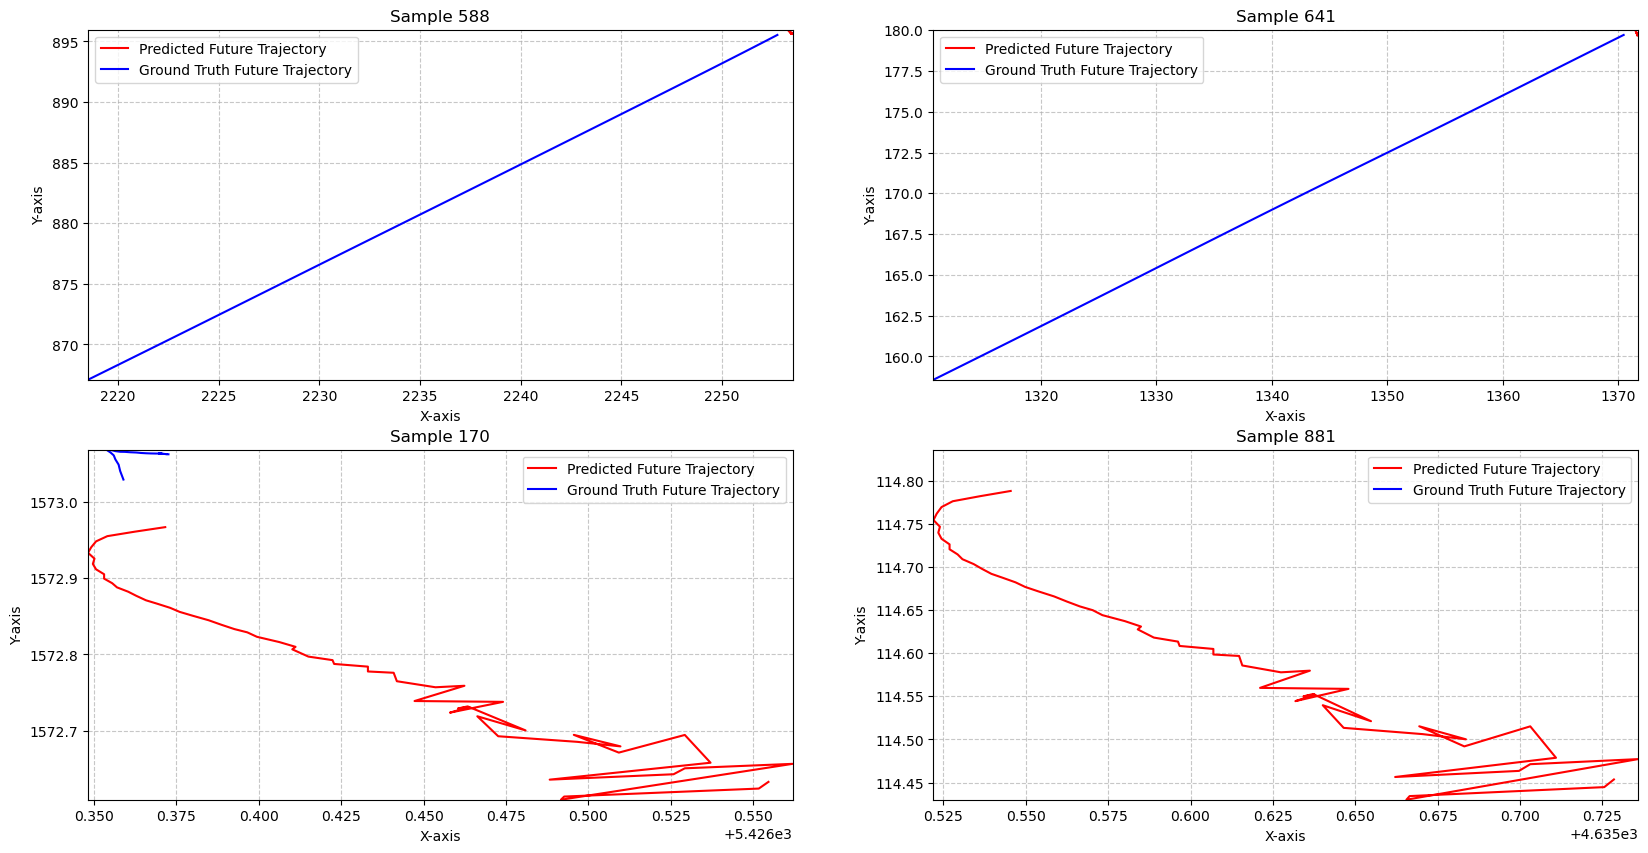

In [87]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

# 1. Constant velocity

### Training

In [22]:
# Split x and y for train data.
# (for all scenes, agents, dims) first 50 time steps, (for 0th agent) 50th and above time step, only position data
# train_x, train_y = train_data[..., :50, :], train_data[:, 0, 50:, :2]
train_x, train_y = train_data[:8000, :, :50, :], train_data[:8000, 0, 50:, :2]
val_x, val_y = train_data[8000:, :, :50, :], train_data[8000:, 0, 50:, :2]

# Get the average velocity of the prediction agent
# (for all scenes, agents, dims) first 50 time steps, (for 0th agent) 50th and above time step, only position data
velocity_diff = train_x[...,1:, :2] - train_x[...,:-1, :2]
print(velocity_diff.shape)

constant_vel = np.mean(velocity_diff[:,0, :, :], axis=-2)
print(constant_vel.shape)

(8000, 50, 49, 2)
(8000, 2)


In [23]:
# Create pred_y_train
pred_y_train = np.zeros((8000, 60, 2))
starting_point = train_x[:, 0, -1, :2] # shape (10000, 2)

for t in range(60):
    pred_y_train[:,t,:] = starting_point + (t+1) * constant_vel

print(pred_y_train.shape)

(8000, 60, 2)


In [24]:
# Calculate train loss
mse = ((train_y - pred_y_train)**2).mean()
print(mse)

54.31656758145893


### Validation

In [25]:
# Get the average velocity of the prediction agent
velocity_diff = val_x[...,1:, :2] - val_x[...,:-1, :2]
print(velocity_diff.shape)

constant_vel = np.mean(velocity_diff[:,0, :, :], axis=-2)
print(constant_vel.shape)

(2000, 50, 49, 2)
(2000, 2)


In [26]:
# Create pred_y for val set
pred_y_val = np.zeros((2000, 60, 2))
starting_point = val_x[:, 0, -1, :2]

for t in range(60):
    pred_y_val[:,t,:] = starting_point + (t+1) * constant_vel

print(pred_y_val.shape)

(2000, 60, 2)


In [27]:
# Calculate val loss
mse = ((val_y - pred_y_val)**2).mean()
print(mse)

53.66489889391673


## 2. Linear Regression

In [20]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [18]:
model = LinearRegressionModel().to(device)

early_stopping_patience = 10
no_improvement = 0
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) 

train_val(50, model)

LinearRegressionModel(
  (linear): Linear(in_features=5000, out_features=120, bias=True)
)


Epoch:   2%|▏         | 1/50 [00:05<04:16,  5.24s/epoch]

Epoch 000 | Learning rate 0.000000 | train normalized MSE 31976.7400 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:   4%|▍         | 2/50 [00:10<04:08,  5.17s/epoch]

Epoch 001 | Learning rate 0.000000 | train normalized MSE 39834.8249 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:   6%|▌         | 3/50 [00:15<04:01,  5.15s/epoch]

Epoch 002 | Learning rate 0.000000 | train normalized MSE 40693.9008 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:   8%|▊         | 4/50 [00:20<03:56,  5.14s/epoch]

Epoch 003 | Learning rate 0.000000 | train normalized MSE 40884.0038 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:  10%|█         | 5/50 [00:25<03:51,  5.13s/epoch]

Epoch 004 | Learning rate 0.000000 | train normalized MSE 40213.8928 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:  12%|█▏        | 6/50 [00:30<03:44,  5.11s/epoch]

Epoch 005 | Learning rate 0.000000 | train normalized MSE 40593.9612 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:  14%|█▍        | 7/50 [00:35<03:39,  5.10s/epoch]

Epoch 006 | Learning rate 0.000000 | train normalized MSE 40763.2050 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:  16%|█▌        | 8/50 [00:40<03:33,  5.09s/epoch]

Epoch 007 | Learning rate 0.000000 | train normalized MSE 39970.1340 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:  18%|█▊        | 9/50 [00:46<03:29,  5.11s/epoch]

Epoch 008 | Learning rate 0.000000 | train normalized MSE 40013.8512 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:  20%|██        | 10/50 [00:51<03:23,  5.08s/epoch]

Epoch 009 | Learning rate 0.000000 | train normalized MSE 39952.0782 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797


Epoch:  20%|██        | 10/50 [00:56<03:44,  5.62s/epoch]

Epoch 010 | Learning rate 0.000000 | train normalized MSE 39817.1954 | val normalized MSE 22012.1871, | val MAE 658.5402 | val MSE 1078597.1797
Early stop!


## 3. Multi-layer perceptron

In [21]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [19]:
model = MLP(50 * 50 * 6, 60 * 2).to(device)

early_stopping_patience = 10
no_improvement = 0
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) 

train_val(50, model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=15000, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=120, bias=True)
  )
)


Epoch:   2%|▏         | 1/50 [00:06<05:09,  6.32s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE  30.7107 | val normalized MSE   5.9337, | val MAE   9.4232 | val MSE 290.7524


Epoch:   4%|▍         | 2/50 [00:12<04:59,  6.24s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   6.3343 | val normalized MSE   5.9335, | val MAE   9.4232 | val MSE 290.7408


Epoch:   6%|▌         | 3/50 [00:18<04:51,  6.19s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   6.5460 | val normalized MSE   5.9335, | val MAE   9.4102 | val MSE 290.7425


Epoch:   8%|▊         | 4/50 [00:24<04:43,  6.16s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   6.3163 | val normalized MSE   5.9335, | val MAE   9.4098 | val MSE 290.7396


Epoch:  10%|█         | 5/50 [00:30<04:36,  6.14s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   6.2845 | val normalized MSE   5.9335, | val MAE   9.4032 | val MSE 290.7423


Epoch:  12%|█▏        | 6/50 [00:36<04:28,  6.11s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   6.4783 | val normalized MSE   5.9334, | val MAE   9.4067 | val MSE 290.7386


Epoch:  14%|█▍        | 7/50 [00:42<04:22,  6.10s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   7.3141 | val normalized MSE   5.9334, | val MAE   9.4161 | val MSE 290.7372


Epoch:  16%|█▌        | 8/50 [00:49<04:17,  6.13s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   6.4078 | val normalized MSE   5.9335, | val MAE   9.4092 | val MSE 290.7403


Epoch:  18%|█▊        | 9/50 [00:55<04:11,  6.14s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   6.3157 | val normalized MSE   5.9335, | val MAE   9.4057 | val MSE 290.7400


Epoch:  20%|██        | 10/50 [01:01<04:06,  6.15s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   6.2870 | val normalized MSE   5.9334, | val MAE   9.4217 | val MSE 290.7364


Epoch:  20%|██        | 10/50 [01:07<04:30,  6.77s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   6.7301 | val normalized MSE   5.9335, | val MAE   9.4275 | val MSE 290.7399
Early stop!


# Creating predictions on test set for leaderboard

In [89]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")

# model = LinearRegressionModel().to(device)
model = MLP(50 * 50 * 6, 60 * 2).to(device)


model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)